In [1]:
import os
import warnings
import numpy as np
import scanpy as sc
import custom_tools
import anndata as ad
import seaborn as sns
import decoupler as dc
from pathlib import Path
from matplotlib import rcParams
import matplotlib.pyplot as plt
from dataset import TissueDataset
from pathlib import Path
import matplotlib


warnings.simplefilter(action='ignore')
sc.settings.verbosity = 0
# Set figure params
sc.set_figure_params(scanpy=True, facecolor="white", dpi=80, dpi_save=300)


In [2]:
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact

def compare_proportions(population1, population2, cell_type='T-cell', use_fisher=False):
    """
    Compares the proportions of a specific cell type (e.g., T-cell) in two populations.

    Parameters:
    - population1: list of cell types in the first population
    - population2: list of cell types in the second population
    - cell_type: the cell type to compare (default is 'T-cell')
    - use_fisher: bool, whether to use Fisher's exact test instead of Chi-square (for smaller sample sizes)
    # teset deneme 

    Returns:
    - p-value: The p-value indicating statistical significance
    - stat_test: The type of test used ('Chi-square' or 'Fisher Exact')
    """
    # Count occurrences of the cell type in both populations
    t_cell_count1 = population1.count(cell_type)
    t_cell_count2 = population2.count(cell_type)
    print(t_cell_count1, t_cell_count2)
    
    # Get the total population sizes
    total1 = len(population1)
    total2 = len(population2)
    
    # Create a 2x2 contingency table for the proportions of T-cells vs non-T-cells
    contingency_table = [
        [t_cell_count1, total1 - t_cell_count1],  # Population 1 (T-cell vs non-T-cell)
        [t_cell_count2, total2 - t_cell_count2]   # Population 2 (T-cell vs non-T-cell)
    ]
    print(contingency_table)
    if use_fisher:
        # Use Fisher's exact test (works for small sample sizes)
        _, p_value = fisher_exact(contingency_table)
        stat_test = "Fisher Exact"
    else:
        # Use Chi-square test for larger samples
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        stat_test = "Chi-square"

    return p_value, stat_test

<h1>Loading model and dataset</h1>

In [3]:
# Read json file
# exp_name = "GATV2_NegativeLogLikelihood_month_04-12-2023"
# job_id = "fombnNMthdocYhDPmAjaBQ"
exp_name = "JacksonFischer"
dataset_name = "JacksonFischer"
# job_id = "2mYvWJwUarIJkw0vvUbl3Q"
job_id = "JF"
PLT_PATH = f"../plots/analysis/{exp_name}_{job_id}"
Path(PLT_PATH).mkdir(parents=True, exist_ok=True)
device =  custom_tools.get_device()
args  = custom_tools.load_json(f"../models/{exp_name}/{job_id}.json")



# args["num_node_features"] = 33
deg = None
if "PNA" in exp_name:
    deg = custom_tools.load_pickle(f"../models/{exp_name}/{job_id}_deg.pckl")
model = custom_tools.load_model(f"{job_id}_SD", path = f"../models/{exp_name}", model_type = "SD", args = args, deg=deg, label_type = "regression", device=device)
dataset = TissueDataset(os.path.join(f"../data/{dataset_name}", "month"),  "month")

# Read the explanations adata
adata_exp = sc.read_h5ad(f"../data/out_data/adatafiles/{dataset_name}/{exp_name}_{job_id}_concatenated_explanations.h5ad")
adata_exp.obs_names_make_unique()

# for mod in model.modules():
#    print(mod)



Seed set to 42
Seed set to 42


GPU is available on this device!
Target prediction: OSmonth


In [4]:
imp_threshold = 0.75
# Get the importance of the nodes
node_importance = np.array(adata_exp.obs["importance"])
node_imp_thr = np.quantile(node_importance, imp_threshold)

importances_hard_v2 = np.array(node_importance > node_imp_thr, dtype="str")
# print("importances_hard", importances_hard)
importances_hard_v2 = pd.Series(importances_hard_v2, dtype="category")
# print(importances_hard)
adata_exp.obs["importance_hard"] = importances_hard_v2.values


class
Immune    0.156587
Stroma    0.270059
Tumor     0.551553
Vessel    0.021801
Name: img_id, dtype: float64
class
Immune    0.156620
Stroma    0.291595
Tumor     0.524948
Vessel    0.026838
Name: img_id, dtype: float64


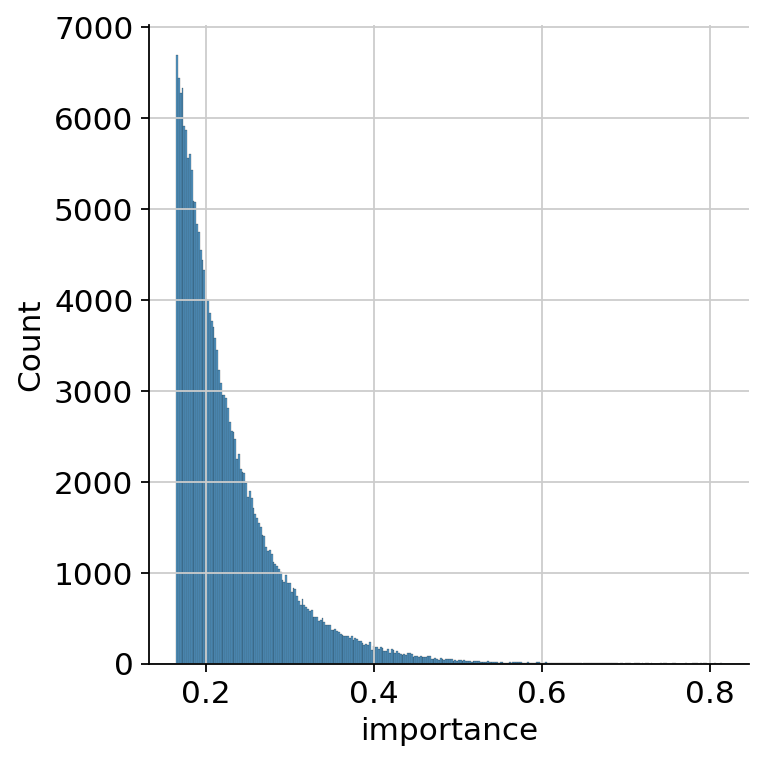

In [5]:


sns.displot(adata_exp.obs[adata_exp.obs["importance_hard"]=="True"], x="importance", bins=300)
adata_exp.obs[adata_exp.obs["importance_hard"]=="True"]


print(adata_exp.obs[adata_exp.obs["importance_hard"]=="True"].groupby("class").agg("count")["img_id"] / adata_exp.obs[adata_exp.obs["importance_hard"]=="True"].groupby("class").agg("count")["img_id"].sum())

print(adata_exp.obs.groupby("class").agg("count")["img_id"] / adata_exp.obs.groupby("class").agg("count")["img_id"].sum())


In [6]:
import embeddings
emd, related_data = embeddings.get_intermediate_embeddings_for_dataset(model, dataset, batch_size=1)
emd_cnv, related_data_cnv = embeddings.get_intermediate_embeddings_for_dataset(model, dataset, mode="CNV", batch_size=1)

In [7]:
embedding_arr = np.array(emd[0])
pid_list, img_id_list, osmonth_lst,  clinical_type_lst, tumor_grade_lst, censor_lst= [], [], [], [], [], []
for data in related_data:
    pid_list.append(str(data.p_id[0]))
    osmonth_lst.append(data.osmonth.item())
    img_id_list.append(data.img_id[0])
    clinical_type_lst.append(data.clinical_type[0])
    tumor_grade_lst.append(str(data.tumor_grade.item()))
    censor_lst.append(data.is_censored[0].item())
embedding_arr.shape

(1114, 128)

In [8]:
adata_emb = ad.AnnData(embedding_arr)
adata_emb.var_names = [f"emb_{i}" for i in range(embedding_arr.shape[1])]
adata_emb.obs_names = img_id_list
adata_emb.obs["img_id"] = img_id_list
adata_emb.obs["img_id"] = adata_emb.obs["img_id"].astype("category")
adata_emb.obs["osmonth"] = osmonth_lst
adata_emb.obs["p_id"] = pid_list
adata_emb.obs["clinical_type"] = clinical_type_lst
adata_emb.obs["tumor_grade"] = tumor_grade_lst
adata_emb.obs["is_censored"] = censor_lst

In [9]:
sc.tl.pca(adata_emb, svd_solver='arpack', random_state=0)
sc.pp.neighbors(adata_emb)
sc.tl.leiden(adata_emb, key_added = "leiden", resolution=0.1)
sc.tl.umap(adata_emb)
# sc.pl.umap(adata, color=["osmonth", "leiden"])
upper_quartile = int(np.quantile(adata_emb.obs["osmonth"], 0.75))
lower_quartile = int(np.quantile(adata_emb.obs["osmonth"], 0.25))

adata_emb.obs["high_surv"]="0"
adata_emb.obs["low_surv"]="0"

adata_emb.obs.loc[adata_emb.obs["osmonth"]>upper_quartile, "high_surv" ] = "1"
adata_emb.obs.loc[adata_emb.obs["osmonth"]<lower_quartile, "low_surv" ] = "1"



In [ ]:
cmap = sns.palettes.get_colormap("tab20")
color_dict = dict()

for ind, clust_index in enumerate(adata_emb.obs["leiden"].cat.categories):
    color_dict[clust_index] = cmap.colors[ind]

rcParams['figure.figsize']=(10,8)
sc.pl.umap(adata_emb, color=["osmonth", "leiden"], palette=color_dict, show=False, legend_loc = 'on data') #, save="_jacksonfisher_embedding_boxplot.pdf")
plt.tight_layout()
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_embedding_umap.pdf"), dpi=300)


fig = plt.figure(figsize=(6, 5))
sns.boxplot(data=adata_emb.obs, x="leiden", y="osmonth", palette= color_dict)
plt.tight_layout()
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_embedding_boxplot.pdf"), dpi=300)
# sc.pl.umap(adata, color=["leiden"], palette=color_dict, legend_loc = 'on data')
# sc.pl.umap(adata, color=["high_surv", "low_surv"], palette=["grey", "black"])
# sc.pl.umap(adata, color=["is_censored"], palette=["grey", "black"])

# sc.pl.dotplot(adata, n_genes=5, groupby='bulk_labels', dendrogram=True)

# sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
# sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, key=f"t-test", show=True, groupby=f"leiden")

<h2>Create Pseudobulk Profile (Important Nodes)</h2>

In [ ]:
pdata_imp_vs_unimp = dc.get_pseudobulk(
    adata_exp,
    sample_col='img_id',
    groups_col='importance_hard',
    mode='mean',
    min_cells=0,
    min_counts=0
)

# create a new pseudobulk anndata with only important nodes
pdata_imp = pdata_imp_vs_unimp[pdata_imp_vs_unimp.obs_names.str.contains("True"),:].copy()
new_obs_names = [obs_n.split("_")[0] for obs_n in pdata_imp.obs_names]
pdata_imp.obs_names = new_obs_names

pdata_imp.obs["leiden"] = adata_emb.obs["leiden"]
pdata_imp.obsm["X_umap"] = adata_emb.obsm["X_umap"]

"""sc.tl.rank_genes_groups(pdata_imp, groupby=f"leiden", method='wilcoxon', groups=["0", "2"], key_added = f"wilcoxon")

rcParams['figure.figsize']=(4,4)
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'axes.labelsize' : 10}) 

sc.pl.rank_genes_groups(pdata_imp, n_genes=5, sharey=False,  key=f"wilcoxon", show=False, groupby="leiden")
plt.tight_layout()
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_ranking.pdf"), dpi=300)

rcParams['figure.figsize']=(4,10)
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'axes.labelsize' : 10}) 
sc.pl.rank_genes_groups_dotplot(pdata_imp, n_genes=5, standard_scale='var', key=f"wilcoxon", figsize = (8,8), show=False, groupby="leiden")
plt.gcf().subplots_adjust(top = 0.60, bottom=0.50)
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_dotplot.pdf"), dpi=300)
"""




sc.tl.rank_genes_groups(pdata_imp, groupby=f"leiden", method='wilcoxon', key_added = f"wilcoxon_all")

rcParams['figure.figsize']=(4,4)
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'axes.labelsize' : 10}) 

sc.pl.rank_genes_groups(pdata_imp, n_genes=5, sharey=False,  key=f"wilcoxon_all", show=True, groupby="leiden")
plt.tight_layout()
# plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_ranking.pdf"), dpi=300)

rcParams['figure.figsize']=(4,3)
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'axes.labelsize' : 10}) 
sc.pl.rank_genes_groups(pdata_imp, n_genes=5, standard_scale='var', key=f"wilcoxon_all", figsize = (8,8), show=False, groupby="leiden")
sc.pl.rank_genes_groups_dotplot(pdata_imp, n_genes=5, standard_scale='var', key=f"wilcoxon_all", figsize = (8,8), show=False, groupby="leiden")
plt.gcf().subplots_adjust(top = 0.60, bottom=0.50)
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_dotplot_one_vs_all.pdf"), dpi=300)
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_dotplot_one_vs_all.png"), dpi=300)

In [ ]:
# 1. Build a mapping from img_id → dominant leiden cluster
leiden_map = (
    adata_emb.obs.groupby("img_id")["leiden"]
    .agg(lambda x: x.value_counts().index[0])  # mode
)

# 2. Map to adata_emb.obs based on img_id
adata_exp.obs["leiden"] = adata_exp.obs["img_id"].map(leiden_map)

# (Optional) Make it categorical for plotting, etc.
adata_exp.obs["leiden"] = adata_exp.obs["leiden"].astype("category")

In [17]:
adata_exp.obs

,clinical_type,img_id,p_id,tumor_grade,osmonth,importance,importance_hard,cell_type,class,leiden
0,HR+HER2-,381ul,97-basel,tensor([3]),107.0,0.031672,False,CK+ HR+,Tumor,0
1,HR+HER2-,381ul,97-basel,tensor([3]),107.0,0.041892,False,CK+ HR+,Tumor,0
2,HR+HER2-,381ul,97-basel,tensor([3]),107.0,0.049177,False,CK+ HR+,Tumor,0
3,HR+HER2-,381ul,97-basel,tensor([3]),107.0,0.058623,False,CK+ HR+,Tumor,0
4,HR+HER2-,381ul,97-basel,tensor([3]),107.0,0.056617,False,CK+ HR+,Tumor,0
...,...,...,...,...,...,...,...,...,...,...
687-586,HR+HER2-,53ur,256-basel,tensor([1]),86.0,0.238997,True,Vimentin hi,Stroma,1
688-583,HR+HER2-,53ur,256-basel,tensor([1]),86.0,0.103589,False,Small elongated,Stroma,1
689-582,HR+HER2-,53ur,256-basel,tensor([1]),86.0,0.046028,False,Macrophage,Immune,1
690-578,HR+HER2-,53ur,256-basel,tensor([1]),86.0,0.000000,False,Endothelial,Vessel,1


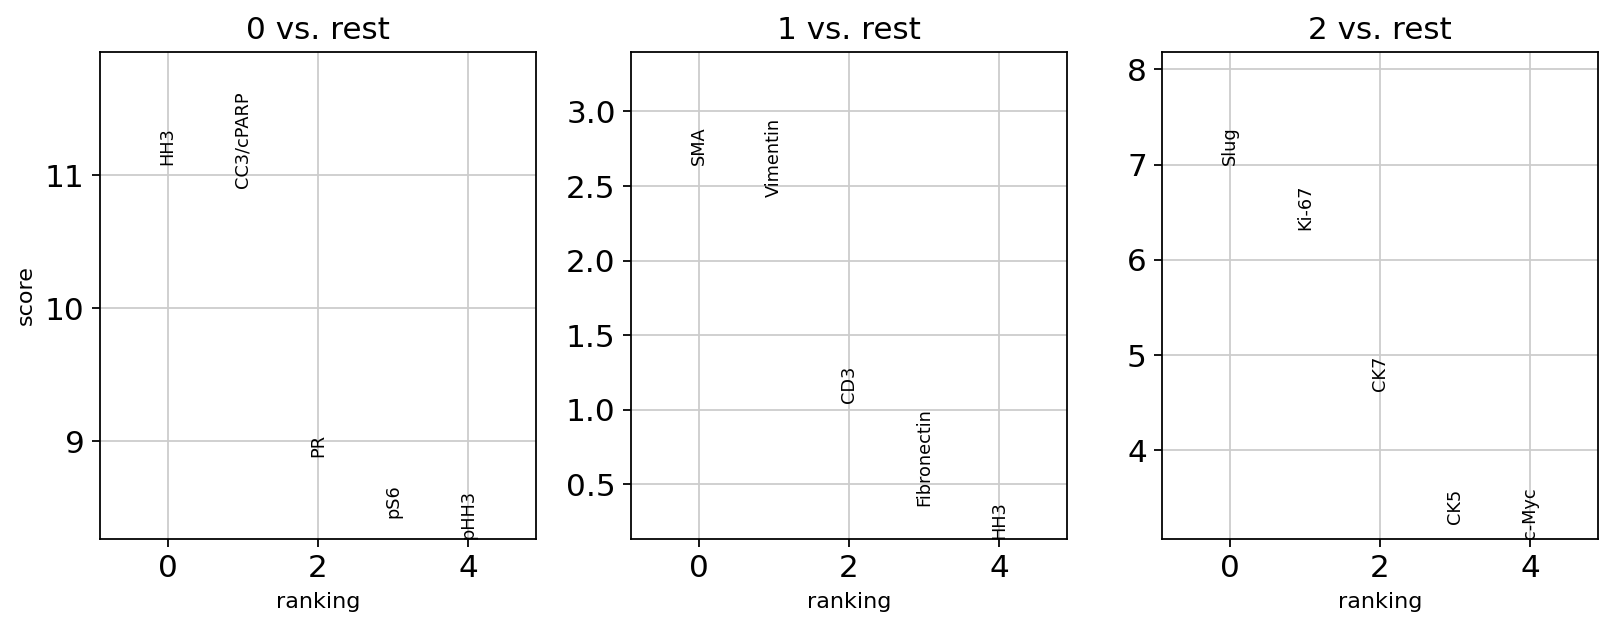

<Figure size 320x320 with 0 Axes>

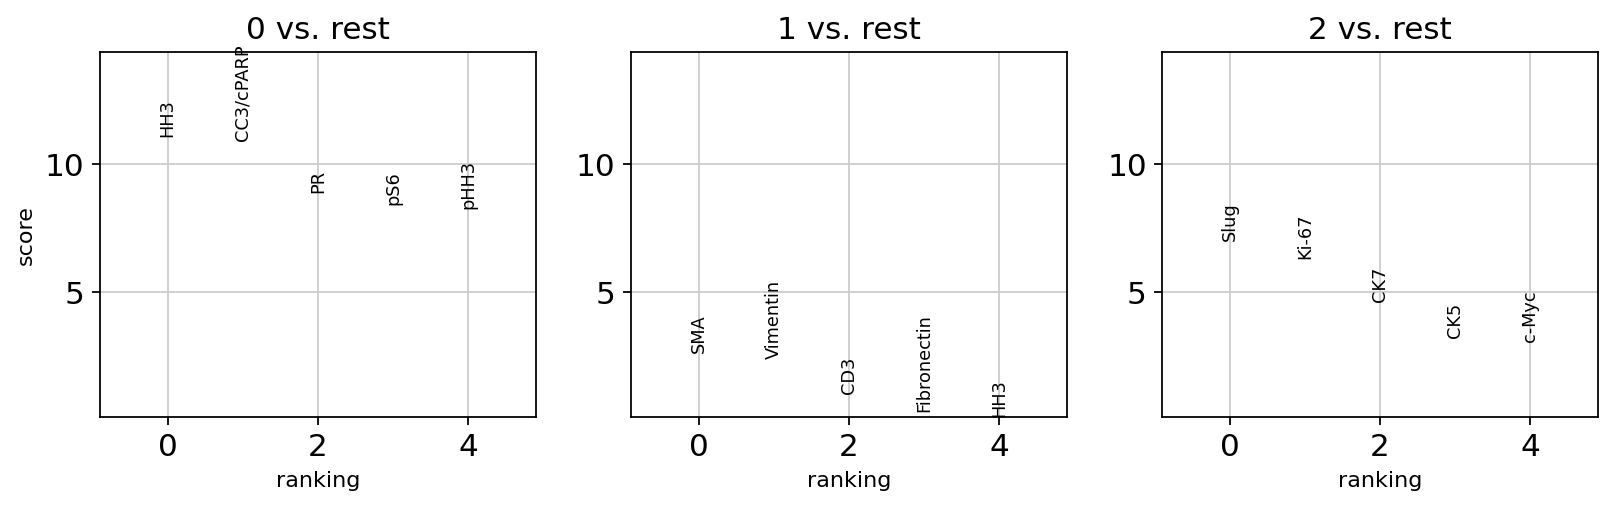

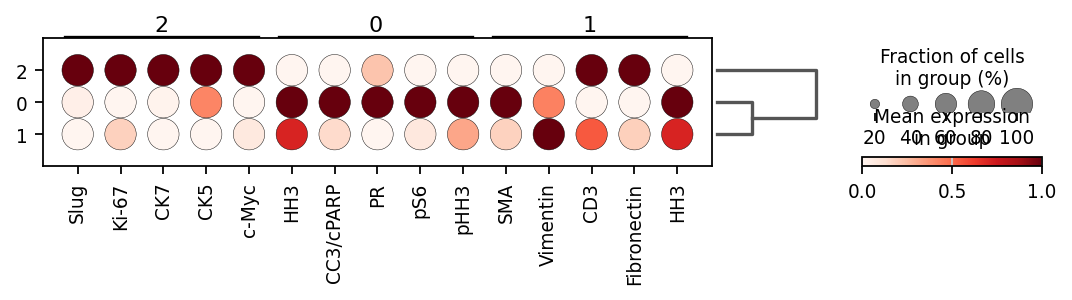

In [23]:
pdata_imp_vs_unimp = dc.get_pseudobulk(
    adata_exp,
    sample_col="img_id",
    groups_col='leiden',
    mode='mean',
    min_cells=200,
    min_counts=0
)

# create a new pseudobulk anndata with only important nodes
# pdata_imp = pdata_imp_vs_unimp[pdata_imp_vs_unimp.obs_names.str.contains("True"),:].copy()
new_obs_names = [obs_n.split("_")[0] for obs_n in pdata_imp_vs_unimp.obs_names]
pdata_imp_vs_unimp.obs_names = new_obs_names

# pdata_imp_vs_unimp.obs["leiden"] = adata_emb.obs["leiden"]
# pdata_imp_vs_unimp.obsm["X_umap"] = adata_emb.obsm["X_umap"

# sc.tl.rank_genes_groups(pdata_imp_vs_unimp, groupby=f"leiden", method='wilcoxon', groups=["0", "2"], key_added = f"wilcoxon_all")
sc.tl.rank_genes_groups(pdata_imp_vs_unimp, groupby=f"leiden", method='wilcoxon', key_added = f"wilcoxon_all")

rcParams['figure.figsize']=(4,4)
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'axes.labelsize' : 10}) 

sc.pl.rank_genes_groups(pdata_imp_vs_unimp, n_genes=5, sharey=False,  key=f"wilcoxon_all", show=True, groupby="leiden")
plt.tight_layout()
# plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_ranking.pdf"), dpi=300)

rcParams['figure.figsize']=(4,3)
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'axes.labelsize' : 10}) 
sc.pl.rank_genes_groups(pdata_imp_vs_unimp, n_genes=5, standard_scale='var', key=f"wilcoxon_all", figsize = (8,8), show=False, groupby="leiden")
sc.pl.rank_genes_groups_dotplot(pdata_imp_vs_unimp, n_genes=5, standard_scale='var', key=f"wilcoxon_all", figsize = (8,8), show=False, groupby="leiden")
plt.gcf().subplots_adjust(top = 0.60, bottom=0.50)
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_all_nodes_dotplot_one_vs_all.pdf"), dpi=300)
plt.show()

# plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_dotplot_one_vs_all.png"), dpi=300)

In [ ]:
pdata_imp_vs_unimp.obs

In [ ]:
# TODO: Add leiden clusters to adata_exp

for cat in adata_emb.obs["leiden"].cat.categories:
    img_ids = adata_emb[adata_emb.obs["leiden"]==cat].obs["img_id"].cat.categories
    adata_exp.obs.loc[adata_exp.obs["img_id"].isin(img_ids), "leiden"] = cat

print(sorted(adata_emb[adata_emb.obs["leiden"]=="0"].obs["img_id"].cat.categories))

In [ ]:
# Clinical Subtype Pie Charts - Each slice shows cluster percentages

def create_clinical_subtype_pie_charts_with_cluster_percentages(adata, group_col="leiden", clinical_col="clinical_type", 
                                                               save_path=None, figsize=(15, 10)):
    """
    Create pie charts showing cluster percentages for each clinical subtype.
    Each clinical subtype gets its own pie chart, with slices representing cluster percentages.
    """
    df = adata.obs[[group_col, clinical_col]].copy()
    
    # Filter out 'nan' string values and actual NaN values
    print(f"Original data shape: {df.shape}")
    print(f"Unique clinical_type values: {df[clinical_col].unique()}")
    
    # Filter out both string 'nan' and actual NaN values
    df_clean = df[~((df[clinical_col] == 'nan') | df[clinical_col].isna())]
    print(f"After removing 'nan' and NaN values: {df_clean.shape}")
    print(f"Removed {df.shape[0] - df_clean.shape[0]} samples with 'nan' or NaN clinical_type")
    
    if df_clean.empty:
        print("Warning: No data remaining after filtering 'nan' and NaN values!")
        return None
    
    # Create contingency table
    contingency_table = pd.crosstab(df_clean[group_col], df_clean[clinical_col])
    
    # Calculate cluster percentages for each clinical subtype
    cluster_percentages = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100
    
    print(f"\nCluster percentages for each clinical subtype:")
    print(cluster_percentages.round(2))
    
    # Get clinical subtypes and clusters
    clinical_subtypes = sorted(cluster_percentages.columns)
    clusters = sorted(cluster_percentages.index)
    
    # Create subplots
    n_subtypes = len(clinical_subtypes)
    n_cols = min(3, n_subtypes)  # Max 3 columns
    n_rows = (n_subtypes + n_cols - 1) // n_cols  # Ceiling division
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # Handle different subplot configurations
    if n_subtypes == 1:
        axes = [axes]  # Single subplot
    elif n_rows == 1 and n_cols > 1:
        axes = axes.reshape(1, -1)  # Single row, multiple columns
    elif n_rows > 1 and n_cols == 1:
        axes = axes.reshape(-1, 1)  # Multiple rows, single column
    elif n_rows == 1 and n_cols == 1:
        axes = [[axes]]  # Single subplot in 2D array
    # If n_rows > 1 and n_cols > 1, axes is already correct
    
    # Color palette for clusters
    colors = plt.cm.Set3(np.linspace(0, 1, len(clusters)))
    color_dict = dict(zip(clusters, colors))
    
    # Create pie chart for each clinical subtype
    for i, subtype in enumerate(clinical_subtypes):
        row = i // n_cols
        col = i % n_cols
        
        # Get the correct axis based on subplot configuration
        if n_subtypes == 1:
            ax = axes[0]  # Single subplot
        elif n_rows == 1 and n_cols > 1:
            ax = axes[0, col]  # Single row, multiple columns
        elif n_rows > 1 and n_cols == 1:
            ax = axes[row, 0]  # Multiple rows, single column
        elif n_rows == 1 and n_cols == 1:
            ax = axes[0, 0]  # Single subplot in 2D array
        else:
            ax = axes[row, col]  # Multiple rows and columns
        
        # Get cluster percentages for this clinical subtype
        subtype_percentages = cluster_percentages[subtype]
        
        # Filter out very small percentages for cleaner visualization
        threshold = 1.0  # 1%
        significant_percentages = subtype_percentages[subtype_percentages >= threshold]
        other_percentage = subtype_percentages[subtype_percentages < threshold].sum()
        
        if other_percentage > 0:
            significant_percentages['Other'] = other_percentage
        
        # Create pie chart
        wedges, texts, autotexts = ax.pie(significant_percentages.values, 
                                        labels=[f'Cluster {c}' for c in significant_percentages.index],
                                        colors=[color_dict.get(c, 'gray') for c in significant_percentages.index],
                                        autopct='%1.1f%%',
                                        startangle=90)
        
        # Show detailed information for each cluster in this clinical subtype
        subtype_counts = contingency_table[subtype]
        total_subtype_count = subtype_counts.sum()
        
        count_info = f"n={total_subtype_count}\n"
        for cluster in clusters:
            if subtype_counts[cluster] > 0:
                percentage = subtype_percentages[cluster]
                count_info += f"Cluster {cluster}: {subtype_counts[cluster]} ({percentage:.1f}%)\n"
        
        ax.set_title(f'{subtype}\n{count_info.strip()}', 
                    fontsize=10, fontweight='bold')
        
        # Improve text readability
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(9)
    
    # Hide empty subplots
    for i in range(n_subtypes, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        
        # Get the correct axis to hide based on subplot configuration
        if n_subtypes == 1:
            pass  # No empty subplots to hide
        elif n_rows == 1 and n_cols > 1:
            axes[0, col].set_visible(False)
        elif n_rows > 1 and n_cols == 1:
            axes[row, 0].set_visible(False)
        elif n_rows == 1 and n_cols == 1:
            pass  # No empty subplots to hide
        else:
            axes[row, col].set_visible(False)
    
    # Add overall legend
    fig.legend([f'Cluster {c}' for c in clusters], title='Clusters', 
            bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.suptitle('Cluster Distribution per Clinical Subtype\nEach slice shows cluster percentage within that clinical subtype', 
                fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Clinical subtype pie charts saved to: {save_path}")
    
    plt.show()
    
    return cluster_percentages

# Create clinical subtype pie charts with cluster percentages
print("\n=== Clinical Subtype Pie Charts (Cluster Percentages) ===")
cluster_percentages = create_clinical_subtype_pie_charts_with_cluster_percentages(
    adata_emb,
    save_path=os.path.join(PLT_PATH, f"{dataset_name}_clinical_subtype_cluster_percentages.pdf")
)

# Print summary of cluster percentages
if cluster_percentages is not None:
    print("\n=== Summary of Cluster Percentages per Clinical Subtype ===")
    print(cluster_percentages.round(2))


In [ ]:
# Combined Pie Charts Function - Both Clinical Type per Cluster AND Cluster per Clinical Subtype

def create_combined_clinical_pie_charts(adata, group_col="leiden", clinical_col="clinical_type", 
                                      save_path=None, figsize=(20, 15)):
    """
    Create both types of pie charts:
    1. Clinical type distribution per cluster (unnormalized)
    2. Cluster distribution per clinical subtype (normalized)
    """
    df = adata.obs[[group_col, clinical_col]].copy()
    
    # Filter out 'nan' string values and actual NaN values
    print(f"Original data shape: {df.shape}")
    print(f"Unique clinical_type values: {df[clinical_col].unique()}")
    
    # Filter out both string 'nan' and actual NaN values
    df_clean = df[~((df[clinical_col] == 'nan') | df[clinical_col].isna())]
    print(f"After removing 'nan' and NaN values: {df_clean.shape}")
    print(f"Removed {df.shape[0] - df_clean.shape[0]} samples with 'nan' or NaN clinical_type")
    
    if df_clean.empty:
        print("Warning: No data remaining after filtering 'nan' and NaN values!")
        return None
    
    # Create contingency table
    contingency_table = pd.crosstab(df_clean[group_col], df_clean[clinical_col])
    
    # Calculate proportions for both directions
    # 1. Clinical type distribution per cluster (unnormalized)
    proportions_unnormalized = contingency_table.div(contingency_table.sum(axis=0), axis=1)
    
    # 2. Cluster distribution per clinical subtype (normalized)
    cluster_percentages = contingency_table.div(contingency_table.sum(axis=0), axis=1) * 100
    
    # Get clusters and clinical types
    clusters = sorted(proportions_unnormalized.index)
    clinical_types = sorted(proportions_unnormalized.columns)
    
    # Create figure with two rows of subplots
    n_clusters = len(clusters)
    n_clinical = len(clinical_types)
    
    # First row: Clinical type per cluster (max 3 columns)
    n_cols_clusters = min(3, n_clusters)
    n_rows_clusters = (n_clusters + n_cols_clusters - 1) // n_cols_clusters
    
    # Second row: Cluster per clinical subtype (max 3 columns)
    n_cols_clinical = min(3, n_clinical)
    n_rows_clinical = (n_clinical + n_cols_clinical - 1) // n_cols_clinical
    
    # Total rows needed
    total_rows = n_rows_clusters + n_rows_clinical
    max_cols = max(n_cols_clusters, n_cols_clinical)
    
    fig, axes = plt.subplots(total_rows, max_cols, figsize=figsize)
    
    # Handle single subplot case
    if total_rows == 1 and max_cols == 1:
        axes = [[axes]]
    elif total_rows == 1:
        axes = axes.reshape(1, -1)
    elif max_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Color palettes
    clinical_colors = plt.cm.Set3(np.linspace(0, 1, len(clinical_types)))
    clinical_color_dict = dict(zip(clinical_types, clinical_colors))
    
    cluster_colors = plt.cm.Set2(np.linspace(0, 1, len(clusters)))
    cluster_color_dict = dict(zip(clusters, cluster_colors))
    
    # ===== FIRST ROW: Clinical Type Distribution per Cluster =====
    print("\n=== Creating Clinical Type Distribution per Cluster ===")
    for i, cluster in enumerate(clusters):
        row = i // n_cols_clusters
        col = i % n_cols_clusters
        
        # Get the correct axis
        if total_rows == 1 and max_cols == 1:
            ax = axes[0, 0]
        elif total_rows == 1:
            ax = axes[0, col]
        elif max_cols == 1:
            ax = axes[row, 0]
        else:
            ax = axes[row, col]
        
        # Get proportions for this cluster
        cluster_props = proportions_unnormalized.loc[cluster]
        
        # Filter out very small proportions
        threshold = 0.01  # 1%
        significant_props = cluster_props[cluster_props >= threshold]
        other_prop = cluster_props[cluster_props < threshold].sum()
        
        if other_prop > 0:
            significant_props['Other'] = other_prop
        
        # Create pie chart
        wedges, texts, autotexts = ax.pie(significant_props.values, 
                                         labels=significant_props.index,
                                         colors=[clinical_color_dict.get(ct, 'gray') for ct in significant_props.index],
                                         autopct='%1.1f%%',
                                         startangle=90)
        
        # Show detailed information
        cluster_counts = contingency_table.loc[cluster]
        cluster_unnorm_props = proportions_unnormalized.loc[cluster]
        total_clinical_counts = contingency_table.sum(axis=0)
        
        count_info = f"n={contingency_table.loc[cluster].sum()}\n"
        for ct in clinical_types:
            if cluster_counts[ct] > 0:
                unnorm_prop = cluster_unnorm_props[ct] * 100
                pct_of_clinical = (cluster_counts[ct] / total_clinical_counts[ct]) * 100
                count_info += f"{ct}: {cluster_counts[ct]} ({unnorm_prop:.1f}% of {ct})\n"
        
        ax.set_title(f'Cluster {cluster}\n{count_info.strip()}', 
                    fontsize=9, fontweight='bold')
        
        # Improve text readability
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(9)
    
    # Hide empty subplots in first row
    for i in range(n_clusters, n_rows_clusters * max_cols):
        row = i // max_cols
        col = i % max_cols
        if total_rows == 1:
            if col < max_cols:
                axes[0, col].set_visible(False)
        elif max_cols == 1:
            if row < total_rows:
                axes[row, 0].set_visible(False)
        else:
            axes[row, col].set_visible(False)
    
    # ===== SECOND ROW: Cluster Distribution per Clinical Subtype =====
    print("\n=== Creating Cluster Distribution per Clinical Subtype ===")
    for i, subtype in enumerate(clinical_types):
        row = n_rows_clusters + (i // n_cols_clinical)
        col = i % n_cols_clinical
        
        # Get the correct axis
        if total_rows == 1 and max_cols == 1:
            ax = axes[0, 0]
        elif total_rows == 1:
            ax = axes[0, col]
        elif max_cols == 1:
            ax = axes[row, 0]
        else:
            ax = axes[row, col]
        
        # Get cluster percentages for this clinical subtype
        subtype_percentages = cluster_percentages[subtype]
        
        # Filter out very small percentages
        threshold = 1.0  # 1%
        significant_percentages = subtype_percentages[subtype_percentages >= threshold]
        other_percentage = subtype_percentages[subtype_percentages < threshold].sum()
        
        if other_percentage > 0:
            significant_percentages['Other'] = other_percentage
        
        # Create pie chart
        wedges, texts, autotexts = ax.pie(significant_percentages.values, 
                                         labels=[f'Cluster {c}' for c in significant_percentages.index],
                                         colors=[cluster_color_dict.get(c, 'gray') for c in significant_percentages.index],
                                         autopct='%1.1f%%',
                                         startangle=90)
        
        # Show detailed information
        subtype_counts = contingency_table[subtype]
        total_subtype_count = subtype_counts.sum()
        
        count_info = f"n={total_subtype_count}\n"
        for cluster in clusters:
            if subtype_counts[cluster] > 0:
                percentage = subtype_percentages[cluster]
                count_info += f"Cluster {cluster}: {subtype_counts[cluster]} ({percentage:.1f}%)\n"
        
        ax.set_title(f'{subtype}\n{count_info.strip()}', 
                    fontsize=10, fontweight='bold')
        
        # Improve text readability
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(9)
    
    # Hide empty subplots in second row
    for i in range(n_clinical, n_rows_clinical * max_cols):
        row = n_rows_clusters + (i // max_cols)
        col = i % max_cols
        if row < total_rows:
            if total_rows == 1:
                if col < max_cols:
                    axes[0, col].set_visible(False)
            elif max_cols == 1:
                axes[row, 0].set_visible(False)
            else:
                axes[row, col].set_visible(False)
    
    # Add legends
    fig.legend(clinical_types, title='Clinical Types', 
              bbox_to_anchor=(1.02, 0.8), loc='upper left')
    
    fig.legend([f'Cluster {c}' for c in clusters], title='Clusters', 
              bbox_to_anchor=(1.02, 0.4), loc='upper left')
    
    plt.suptitle('Clinical Type Analysis - Dual Perspective\n'
                'Top: Clinical Type Distribution per Cluster | Bottom: Cluster Distribution per Clinical Subtype', 
                fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Combined pie charts saved to: {save_path}")
    
    plt.show()
    
    return proportions_unnormalized, cluster_percentages

# Create combined pie charts (both perspectives)
print("\n=== Combined Clinical Type Analysis ===")
proportions_unnorm, cluster_percentages = create_combined_clinical_pie_charts(
    adata_emb,
    save_path=os.path.join(PLT_PATH, f"{dataset_name}_combined_clinical_analysis.pdf")
)

# Print summary of both analyses
if proportions_unnorm is not None and cluster_percentages is not None:
    print("\n=== Summary of Clinical Type Distribution per Cluster ===")
    print(proportions_unnorm.round(3))
    print("\n=== Summary of Cluster Distribution per Clinical Subtype ===")
    print(cluster_percentages.round(2))


In [ ]:
adata_exp.obs.groupby("importance_hard").agg("count")

In [ ]:
def plot_cell_type_proportion(adata, group_col="leiden", obs_col = "cell_type", fl_path = None):
    group_list = list(adata.obs[group_col].cat.categories)
    c_type_list = list(adata.obs[obs_col].cat.categories)
    # print(len(c_type_list))
    #c_type_list.remove("Large elongated")
    #c_type_list.remove("Macrohage")
    if obs_col=="cell_type" and "Macrophage" in c_type_list:
        c_type_list.remove("Macrophage")
    print(len(c_type_list))
    c_type_list = c_type_list[:20]
    for cond in group_list:
        adata_tmp = adata[adata.obs[group_col]==cond,:]
        for c_type in c_type_list:
            if adata_tmp[adata_tmp.obs[obs_col]==c_type].shape[0]<8:
                print(c_type, adata_tmp[adata_tmp.obs[obs_col]==c_type].shape[0])
                c_type_list.remove(c_type)
            # print(c_type, adata_tmp[adata_tmp.obs[obs_col]==c_type].shape[0])
            # cond_arr[-1].append(100*(adata_tmp[adata_tmp.obs[obs_col]==c_type].shape[0]/adata_tmp.shape[0]))
    print(c_type_list)
    
    cond_prop = dict()
    cond_arr = []
    for cond in group_list:
        cond_arr.append([])
        # print(cond, cond_arr)
        cond_prop[cond] = []
        adata_tmp = adata[adata.obs[group_col]==cond,:]
        sum = 0
        for c_type in c_type_list:


            cond_arr[-1].append(100*(adata_tmp[adata_tmp.obs[obs_col]==c_type].shape[0]/(adata_tmp[adata_tmp.obs[obs_col].isin(c_type_list),:].shape[0])))

    data = np.array(cond_arr).T
    # print("data", data.shape)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # cmap = matplotlib.cm.get_cmap('tab20')
    # print(cmap.colors)
    
    X = np.arange(data.shape[1])
    
    for i in range(data.shape[0]):
        print(data[i], c_type_list[i])
        ax1.bar(X, data[i],bottom = np.sum(data[:i], 
                    axis =0), width= 0.85, color = cmap.colors[i], label=c_type_list[i]  )

    ax1.set_xticks([0,1,2])
    ax1.set_xticklabels(group_list) # , rotation=45)
    ax1.set_xlabel("Cluster", fontweight='bold')
    ax1.set_ylabel("Proportion (%)", fontweight='bold')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.subplots_adjust(bottom=0.45)
    fig.tight_layout()
    if fl_path:
        plt.savefig(fl_path)

    plt.show()



In [ ]:
adata_exp.obs["leiden"] = adata_exp.obs["leiden"].astype("category")
# adata_exp[adata_exp.obs["importance_hard"]=="True",:]
# plot_cell_type_proportion(adata_exp[adata_exp.obs["importance_hard"]=="True",:], group_col="leiden", obs_col = "class")
# plot_cell_type_proportion(adata_exp, group_col="leiden", obs_col = "class")

# plot_cell_type_proportion(adata_exp, group_col="leiden", obs_col = "class", fl_path = f"{PLT_PATH}/major_classification_prop_all.pdf")
# plot_cell_type_proportion(adata_exp[adata_exp, group_col="leiden", obs_col = "cell_type", fl_path=f"{PLT_PATH}/cell_class_prop_imp.pdf")

plot_cell_type_proportion(adata_exp[adata_exp.obs["importance_hard"]=="True",:], group_col="leiden", obs_col = "class", fl_path = f"{PLT_PATH}/{dataset_name}_major_classification_prop_imp.pdf")
# plot_cell_type_proportion(adata_exp[adata_exp.obs["importance_hard"]=="False",:], group_col="leiden", obs_col = "class", fl_path = f"{PLT_PATH}/{dataset_name}_major_classification_prop_notimp.pdf")
# plot_cell_type_proportion(adata_exp[adata_exp.obs["importance_hard"]=="True",:], group_col="leiden", obs_col = "cell_type", fl_path=f"{PLT_PATH}/cell_class_prop_imp.pdf")
# plot_cell_type_proportion(adata_exp, group_col="leiden", obs_col = "cell_type")


# Tumor and cell type distribution
selection = (adata_exp.obs["importance_hard"]=="True") & (adata_exp.obs["class"]=="Tumor")
plot_cell_type_proportion(adata_exp[selection,:], group_col="leiden", obs_col = "cell_type", fl_path = f"{PLT_PATH}/{dataset_name}_major_classification_prop_imp_tumor.pdf")


"""
# Tumor and cell type distribution
selection = (adata_exp.obs["importance_hard"]=="True") & (adata_exp.obs["class"]=="Immune")
plot_cell_type_proportion(adata_exp[selection,:], group_col="leiden", obs_col = "cell_type", fl_path = f"{PLT_PATH}/{dataset_name}_major_classification_prop_imp_immune.pdf")

adata_selection = adata_exp[selection,:]

# print(mct, adata_exp_imp_tmp)
population1 = list(adata_selection[adata_selection.obs["leiden"]=="0",:].obs["cell_type"].values)
population2 = list(adata_selection[adata_selection.obs["leiden"]=="2",:].obs["cell_type"].values)
set_cell_types = set(population1) & set(population2) 

ns = []
for ct in set_cell_types:
    p_value, test_used = compare_proportions(population1, population2, cell_type=ct)

    print(f"p-value: {p_value}, Test used: {test_used}")

    if p_value < 0.00001:
        #print(f"The difference in {mct} - {ct} proportions is statistically significant.")
        pass
    else:
        ns.append(ct)
        print(f"The difference in {ct} proportions is not statistically significant.")

# plot_cell_type_proportion(adata_exp[(adata_exp.obs["importance_hard"]=="True") & (adata_exp.obs["class"]=="Tumor") ,:], group_col="leiden", obs_col = "cell_type", fl_path=f"{PLT_PATH}/cell_class_prop_imp.pdf")

"""


In [ ]:


adata_exp_imp = adata_exp[adata_exp.obs["importance_hard"]=="True",:]
set_major_ct = set(list(adata_exp_imp.obs["class"].values)) - {"Vessel"}



# print(mct, adata_exp_imp_tmp)
population1 = list(adata_exp_imp[adata_exp_imp.obs["leiden"]=="0",:].obs["cell_type"].values)
population2 = list(adata_exp_imp[adata_exp_imp.obs["leiden"]=="2",:].obs["cell_type"].values)
set_cell_types = set(population1) & set(population2) 

ns = []
for ct in set_cell_types:
    p_value, test_used = compare_proportions(population1, population2, cell_type=ct)

    print(f"p-value: {p_value}, Test used: {test_used}")

    if p_value < 0.00001:
        #print(f"The difference in {mct} - {ct} proportions is statistically significant.")
        pass
    else:
        ns.append(ct)
        print(f"The difference in {ct} proportions is not statistically significant.")

print(ns, set_major_ct)
"""for mct in set_major_ct:
    adata_exp_imp_tmp = adata_exp[adata_exp.obs["class"]==mct,:]
    # print(mct, adata_exp_imp_tmp)
    population1 = list(adata_exp_imp_tmp[adata_exp_imp_tmp.obs["leiden"]=="0",:].obs["cell_type"].values)
    population2 = list(adata_exp_imp_tmp[adata_exp_imp_tmp.obs["leiden"]=="2",:].obs["cell_type"].values)
    set_cell_types = set(population1) & set(population2) 

    ns = []
    for ct in set_cell_types:
        print(mct, ct)
        p_value, test_used = compare_proportions(population1, population2, cell_type=ct)

        print(f"p-value: {p_value}, Test used: {test_used}")
    
        if p_value < 0.001:
            #print(f"The difference in {mct} - {ct} proportions is statistically significant.")
            pass
        else:
            ns.append(ct)
            print(f"The difference in {mct} - {ct} proportions is not statistically significant.")

    print(ns, set_major_ct)"""

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from itertools import combinations
from statsmodels.stats.multitest import multipletests
import pickle

df = adata_exp.obs.copy()
# Number of permutations
N_PERMUTATIONS = 10000

# Filter for important cells
df_filtered = df[df["importance_hard"] == "True"]

# Compute counts and proportions
count_table = df_filtered.groupby(["leiden", "cell_type"]).size().unstack(fill_value=0)
prop_table = count_table.div(count_table.sum(axis=1), axis=0)  # Normalize to proportions

    
# print(count_table)
# print(prop_table)
# Function for permutation test
def permutation_test(cluster1, cluster2, cell_type, df, n_permutations=N_PERMUTATIONS):
    # Get observed proportion difference
    observed_diff = abs(prop_table.loc[cluster1, cell_type] - prop_table.loc[cluster2, cell_type])

    # Generate null distribution
    null_diffs = []
    for _ in range(n_permutations):
        shuffled_clusters = np.random.permutation(df["leiden"])  # Shuffle cluster labels
        shuffled_counts = df.copy()
        shuffled_counts["leiden"] = shuffled_clusters
        
        # Recalculate proportions with shuffled data
        shuffled_counts = shuffled_counts.groupby(["leiden", "cell_type"]).size().unstack(fill_value=0)
        shuffled_props = shuffled_counts.div(shuffled_counts.sum(axis=1), axis=0)

        # Compute new proportion difference
        null_diffs.append(abs(shuffled_props.loc[cluster1, cell_type] - shuffled_props.loc[cluster2, cell_type]))

    # Compute empirical p-value
    p_value = (np.sum(np.array(null_diffs) >= observed_diff) + 1) / (n_permutations + 1)
    return p_value

# Perform permutation test for all cell types
p_values_all = {}
posthoc_results = {}

for cell_type in prop_table.columns:
    print(cell_type)
    pairwise_p_values = []
    pairwise_comparisons = []

    # Generate pairwise comparisons for all clusters
    for cluster1, cluster2 in combinations(count_table.index, 2):
        p_value = permutation_test(cluster1, cluster2, cell_type, df_filtered, N_PERMUTATIONS)
        pairwise_p_values.append(p_value)
        pairwise_comparisons.append((cluster1, cluster2))

    # Adjust for multiple testing (FDR correction)
    _, p_adjusted, _, _ = multipletests(pairwise_p_values, method="fdr_bh")

    # Store significant results
    posthoc_results[cell_type] = {pair: p for pair, p in zip(pairwise_comparisons, p_adjusted) if p < 0.001}

# Function to convert p-values into asterisks
def pval_to_stars(p):
    if p < 0.0001:
        return "***"
    elif p < 0.001:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""    


os.makedirs(PLT_PATH, exist_ok=True)

# Plot proportions with significance markers
num_cell_types = len(prop_table.columns)
fig, axes = plt.subplots(nrows=num_cell_types, figsize=(8, num_cell_types * 3), sharex=True)

if num_cell_types == 1:
    axes = [axes]  # Ensure axes is iterable for a single plot

# prop_table
# posthoc_results
# save the edge indices and as a list 

"""with open(os.path.join(PLT_PATH, f'{dataset_name}_prop_table.pickle'), 'wb') as handle:
    pickle.dump(prop_table, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(os.path.join(PLT_PATH, f'{dataset_name}_posthoc_results.pickle'), 'wb') as handle:
    pickle.dump(posthoc_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(os.path.join(PLT_PATH, f'{dataset_name}_p_values_all.pickle'), 'wb') as handle:
    pickle.dump(p_values_all, handle, protocol=pickle.HIGHEST_PROTOCOL)"""

    

"""for ax, cell_type in zip(axes, prop_table.columns):
    print(cell_type, 2)
    # Sort clusters by proportion
    sorted_clusters = prop_table[cell_type].sort_values(ascending=False).index
    sorted_props = prop_table.loc[sorted_clusters, cell_type]

    sns.barplot(x=sorted_clusters, y=sorted_props, ax=ax, palette="viridis")
    ax.set_title(f"Proportion of {cell_type} across clusters\n(Permutation test)")
    ax.set_ylabel("Proportion")
    ax.set_xlabel("Cluster")
    ax.set_ylim(0,0.2)

    # Add statistical significance markers for multiple clusters
    cluster_positions = np.arange(len(sorted_clusters))
    if cell_type in posthoc_results:
        for (cluster1, cluster2), p_val in posthoc_results[cell_type].items():
            print(p_val)
            if cluster1 in sorted_clusters and cluster2 in sorted_clusters:
                y_max = max(sorted_props[cluster1], sorted_props[cluster2]) + 0.05
                x1, x2 = cluster_positions[sorted_clusters == cluster1][0], cluster_positions[sorted_clusters == cluster2][0]

                # Add a line and asterisks
                ax.plot([x1, x1, x2, x2], [y_max, y_max + 0.02, y_max + 0.02, y_max], color="black")
                ax.text((x1 + x2) / 2, y_max + 0.03, pval_to_stars(p_val), ha="center", va="bottom", fontsize=12, color="red")

plt.tight_layout()
plt.savefig(os.path.join(PLT_PATH, f'{dataset_name}_proportions.pdf'))
plt.savefig(os.path.join(PLT_PATH, f'{dataset_name}_proportions.png'))
plt.show()
"""

# Generate separate figures for each cell type
for cell_type in prop_table.columns:
    print("Performing statistical analysis for ", cell_type)
    fig, ax = plt.subplots(figsize=(8, 4))

    # Sort clusters by proportion
    sorted_clusters = prop_table[cell_type].sort_values(ascending=False).index
    sorted_props = prop_table.loc[sorted_clusters, cell_type]

    sns.barplot(x=sorted_clusters, y=sorted_props, ax=ax, palette="viridis")
    ax.set_title(f"Proportion of {cell_type} across clusters\n(Permutation test)")
    ax.set_ylabel("Proportion")
    ax.set_xlabel("Cluster")
    ax.set_ylim(0, 0.2)

    # Add statistical significance markers
    cluster_positions = np.arange(len(sorted_clusters))
    if cell_type in posthoc_results:
        for (cluster1, cluster2), p_val in posthoc_results[cell_type].items():
            if cluster1 in sorted_clusters and cluster2 in sorted_clusters:
                y_max = max(sorted_props[cluster1], sorted_props[cluster2]) + 0.05
                x1, x2 = cluster_positions[sorted_clusters == cluster1][0], cluster_positions[sorted_clusters == cluster2][0]

                # Add line and significance stars
                ax.plot([x1, x1, x2, x2], [y_max, y_max + 0.02, y_max + 0.02, y_max], color="black")
                ax.text((x1 + x2) / 2, y_max + 0.03, pval_to_stars(p_val), ha="center", va="bottom", fontsize=12, color="red")

    # Save each figure separately
    plt.tight_layout()
    plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_proportions_{cell_type}.pdf"))
    plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_proportions_{cell_type}.png"))
    plt.close(fig)  # Close the figure to avoid memory issues

print("Figures saved successfully.")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from itertools import combinations
from statsmodels.stats.multitest import multipletests
import pickle

df = adata_exp.obs.copy()
# Number of permutations
N_PERMUTATIONS = 10000

# Filter for important cells
df_filtered = df[df["importance_hard"] == "True"]

# Compute counts and proportions
count_table = df_filtered.groupby(["leiden", "cell_type"]).size().unstack(fill_value=0)
prop_table = count_table.div(count_table.sum(axis=1), axis=0)  # Normalize to proportions

# Function for permutation test
def permutation_test(cluster1, cluster2, cell_type, df, n_permutations=N_PERMUTATIONS):
    # Get observed proportion difference
    observed_diff = abs(prop_table.loc[cluster1, cell_type] - prop_table.loc[cluster2, cell_type])

    # Generate null distribution
    null_diffs = []
    for _ in range(n_permutations):
        shuffled_df = df.copy()
        
        # Shuffle cell types instead of cluster labels
        shuffled_df["cell_type"] = np.random.permutation(shuffled_df["cell_type"])
        
        # Recalculate proportions with shuffled data
        shuffled_counts = shuffled_df.groupby(["leiden", "cell_type"]).size().unstack(fill_value=0)
        shuffled_props = shuffled_counts.div(shuffled_counts.sum(axis=1), axis=0)

        # Compute new proportion difference
        if cell_type in shuffled_props.columns:
            null_diffs.append(abs(shuffled_props.loc[cluster1, cell_type] - shuffled_props.loc[cluster2, cell_type]))
        else:
            null_diffs.append(0)  # If the cell type is missing in this permutation, assume 0

    # Compute empirical p-value
    p_value = (np.sum(np.array(null_diffs) >= observed_diff) + 1) / (n_permutations + 1)
    return p_value

# Perform permutation test for all cell types
p_values_all = {}
posthoc_results = {}

for cell_type in prop_table.columns:
    print(cell_type)
    pairwise_p_values = []
    pairwise_comparisons = []

    # Generate pairwise comparisons for all clusters
    for cluster1, cluster2 in combinations(count_table.index, 2):
        p_value = permutation_test(cluster1, cluster2, cell_type, df_filtered, N_PERMUTATIONS)
        pairwise_p_values.append(p_value)
        pairwise_comparisons.append((cluster1, cluster2))

    # Adjust for multiple testing (FDR correction)
    _, p_adjusted, _, _ = multipletests(pairwise_p_values, method="fdr_bh")

    # Store significant results
    posthoc_results[cell_type] = {pair: p for pair, p in zip(pairwise_comparisons, p_adjusted) if p < 0.001}

# Function to convert p-values into asterisks
def pval_to_stars(p):
    if p < 0.0001:
        return "***"
    elif p < 0.001:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""


os.makedirs(PLT_PATH, exist_ok=True)

# Plot proportions with significance markers
num_cell_types = len(prop_table.columns)
fig, axes = plt.subplots(nrows=num_cell_types, figsize=(8, num_cell_types * 3), sharex=True)

if num_cell_types == 1:
    axes = [axes]  # Ensure axes is iterable for a single plot

# Generate separate figures for each cell type
for cell_type in prop_table.columns:
    print("Performing statistical analysis for ", cell_type)
    fig, ax = plt.subplots(figsize=(8, 4))

    # Sort clusters by proportion
    sorted_clusters = prop_table[cell_type].sort_values(ascending=False).index
    sorted_props = prop_table.loc[sorted_clusters, cell_type]

    sns.barplot(x=sorted_clusters, y=sorted_props, ax=ax, palette="viridis")
    ax.set_title(f"Proportion of {cell_type} across clusters\n(Permutation test)")
    ax.set_ylabel("Proportion")
    ax.set_xlabel("Cluster")
    ax.set_ylim(0, 0.2)

    # Add statistical significance markers
    cluster_positions = np.arange(len(sorted_clusters))
    if cell_type in posthoc_results:
        for (cluster1, cluster2), p_val in posthoc_results[cell_type].items():
            if cluster1 in sorted_clusters and cluster2 in sorted_clusters:
                y_max = max(sorted_props[cluster1], sorted_props[cluster2]) + 0.05
                x1, x2 = cluster_positions[sorted_clusters == cluster1][0], cluster_positions[sorted_clusters == cluster2][0]

                # Add line and significance stars
                ax.plot([x1, x1, x2, x2], [y_max, y_max + 0.02, y_max + 0.02, y_max], color="black")
                ax.text((x1 + x2) / 2, y_max + 0.03, pval_to_stars(p_val), ha="center", va="bottom", fontsize=12, color="red")

    # Save each figure separately
    plt.tight_layout()
    plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_proportions_{cell_type}.pdf"))
    plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_proportions_{cell_type}.png"))
    plt.close(fig)  # Close the figure to avoid memory issues

print("Figures saved successfully.")

In [ ]:
lower_quartile = int(np.quantile(adata_emb.obs["osmonth"], 0.25))
adata_lower = adata_emb[adata_emb.obs["osmonth"]<lower_quartile,:].copy()

sc.tl.pca(adata_lower, svd_solver='arpack', random_state=0)
sc.pp.neighbors(adata_lower)
sc.tl.umap(adata_lower)

sc.tl.leiden(adata_lower, resolution=0.3, key_added = "leiden_low_surv")

color_dict = dict()
map = sns.palettes.get_colormap("tab20")
color_dict = dict()

for ind, clust_index in enumerate(adata_lower.obs["leiden_low_surv"].cat.categories):
    color_dict[clust_index] = cmap.colors[ind]

rcParams['figure.figsize']=(10,8)
sc.pl.umap(adata_lower, show=False, color=["osmonth", "tumor_grade", "clinical_type", "leiden_low_surv"])
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_lowsurv_embedding_umap.pdf"), dpi=300)
sc.pl.umap(adata_lower, show=False, color="leiden_low_surv", palette=color_dict, legend_loc = 'on data')
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_lowsurv_embedding_clust_umap.pdf"), dpi=300)
plt.clf()
sns.boxplot(data=adata_lower.obs, x="leiden_low_surv", y="osmonth", showfliers = False, palette= color_dict)
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_lowsurv_embedding_boxplot.pdf"), dpi=300)
# sc.pl.violin(adata_lower, 'osmonth', groupby='leiden', palette=color_dict)

pdata_imp_low = pdata_imp[pdata_imp.obs_names.isin(adata_lower.obs_names),:].copy()

pdata_imp_low.obs["leiden_low_surv"] = adata_lower.obs["leiden_low_surv"]
pdata_imp_low.obsm["X_umap"] = adata_lower.obsm["X_umap"]

sc.tl.rank_genes_groups(pdata_imp_low, groupby=f"leiden_low_surv", method='wilcoxon', key_added = f"wilcoxon_low")
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'axes.labelsize' : 10}) 
sc.pl.rank_genes_groups_dotplot(pdata_imp_low, n_genes=5, standard_scale='var', key=f"wilcoxon_low", show=False, groupby="leiden_low_surv")
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_lowsurv_dotplot.pdf"), dpi=300)


In [ ]:
# pdata_imp_vs_unimp.obs

lower_quartile = int(np.quantile(pdata_imp_vs_unimp.obs["osmonth"], 0.20))
print(lower_quartile)
pdata_lower = pdata_imp_vs_unimp[pdata_imp_vs_unimp.obs["osmonth"]<lower_quartile,:].copy()
with plt.rc_context():
    sc.tl.rank_genes_groups(pdata_lower, groupby=f"importance_hard", method='wilcoxon', key_added = f"wilcoxon_importance_hard")
    sc.pl.rank_genes_groups_dotplot(pdata_lower, n_genes=5, standard_scale='var', key=f"wilcoxon_importance_hard", show=False, groupby="importance_hard")
    plt.tight_layout()
    plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_vs_unimp_dotplot.pdf"), dpi=300, bbox_inches='tight')
    plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_vs_unimp_dotplot.png"), dpi=300, bbox_inches='tight')


In [ ]:
with plt.rc_context():
    sc.tl.rank_genes_groups(pdata_imp_vs_unimp, groupby=f"importance_hard", method='wilcoxon', key_added = f"wilcoxon_importance_hard_all")
    sc.pl.rank_genes_groups_dotplot(pdata_imp_vs_unimp, n_genes=4, standard_scale='var', key=f"wilcoxon_importance_hard_all", show=True, groupby="importance_hard")
    plt.tight_layout()

In [ ]:
pdata_lower.obs["importance_hard"]

<h1>Clinical Subtype Analysis - Low vs. High Survivors</h1>

In [ ]:
clinical_type = "HR+HER2-"
adata_emb_clinical_subtype = adata_emb[adata_emb.obs["clinical_type"]==clinical_type,:].copy()
upper_quartile = int(np.quantile(adata_emb_clinical_subtype.obs["osmonth"], 0.75))
lower_quartile = int(np.quantile(adata_emb_clinical_subtype.obs["osmonth"], 0.25))

adata_emb_clinical_subtype.obs["high_surv"]="0"
adata_emb_clinical_subtype.obs["low_surv"]="0"

adata_emb_clinical_subtype.obs.loc[adata_emb_clinical_subtype.obs["osmonth"]>upper_quartile, "high_surv" ] = "1"
adata_emb_clinical_subtype.obs.loc[adata_emb_clinical_subtype.obs["osmonth"]<lower_quartile, "low_surv" ] = "1"

In [ ]:
sc.tl.pca(adata_emb_clinical_subtype, svd_solver='arpack', random_state=42)
sc.pp.neighbors(adata_emb_clinical_subtype)
sc.tl.umap(adata_emb_clinical_subtype)

sc.tl.leiden(adata_emb_clinical_subtype, resolution=0.1, key_added = f"leiden_{clinical_type}")

color_dict = dict()
map = sns.palettes.get_colormap("tab20")
color_dict = dict()

"""old_to_new = dict(
    old_cluster1='new_cluster1',
    old_cluster2='new_cluster1',
    old_cluster3='new_cluster2',
)
adata.obs['new_clusters'] = (
    adata.obs['old_clusters']
    .map(old_to_new)
    .astype('category')
)"""
adata_emb_clinical_subtype.obs[f"leiden_{clinical_type}"][adata_emb_clinical_subtype.obs[f"leiden_{clinical_type}"].isin(["0", "3"])]="0"
adata_emb_clinical_subtype.obs[f"leiden_{clinical_type}"] = adata_emb_clinical_subtype.obs[f"leiden_{clinical_type}"].cat.remove_categories(["3"])
adata_emb_clinical_subtype.obs[f"leiden_{clinical_type}"] = adata_emb_clinical_subtype.obs[f"leiden_{clinical_type}"].cat.rename_categories(np.arange(len(np.unique(adata_emb_clinical_subtype.obs[f"leiden_{clinical_type}"]))).astype('str'))

for ind, clust_index in enumerate(adata_emb_clinical_subtype.obs[f"leiden_{clinical_type}"].cat.categories):
    color_dict[clust_index] = cmap.colors[ind]
rcParams['figure.figsize']=(15,10)
sc.pl.umap(adata_emb_clinical_subtype, size=500, show=False, color=["osmonth",f"leiden_{clinical_type}"]) #  "tumor_grade", "clinical_type"
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_{clinical_type}_embedding_umap.pdf"), dpi=300)
plt.clf()
rcParams['figure.figsize']=(10,8)
sc.pl.umap(adata_emb_clinical_subtype, color=f"leiden_{clinical_type}", show=False, palette=color_dict, legend_loc = 'on data')
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_{clinical_type}_embedding_clust_umap.pdf"), dpi=300)
plt.clf()
sns.boxplot(data=adata_emb_clinical_subtype.obs, x=f"leiden_{clinical_type}", y="osmonth", showfliers = False, palette= color_dict)
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_{clinical_type}_embedding_boxplot.pdf"), dpi=300)

In [ ]:
sc.pl.umap(adata_emb_clinical_subtype, color=f"leiden_{clinical_type}", palette=color_dict, legend_loc = 'on data')
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_{clinical_type}_embedding_clust_umap.pdf"), dpi=300)
plt.clf()

In [ ]:
pdata_clinical_subtype = pdata_imp[pdata_imp.obs_names.isin(adata_emb_clinical_subtype.obs_names),:].copy()

pdata_clinical_subtype.obs[f"leiden_{clinical_type}"] = adata_emb_clinical_subtype.obs[f"leiden_{clinical_type}"]
pdata_clinical_subtype.obsm["X_umap"] = adata_emb_clinical_subtype.obsm["X_umap"]

sc.tl.rank_genes_groups(pdata_clinical_subtype, groupby=f"leiden_{clinical_type}", sharey=False, method='wilcoxon', groups=["0", "1"], key_added = f"wilcoxon_{clinical_type}")
# sc.tl.rank_genes_groups(pdata_clinical_subtype, groupby=f"leiden_{clinical_type}", sharey=False, method='wilcoxon', key_added = f"wilcoxon_{clinical_type}")
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'axes.labelsize' : 10}) 
sc.pl.rank_genes_groups_dotplot(pdata_clinical_subtype, n_genes=5, standard_scale='var', key=f"wilcoxon_{clinical_type}",  figsize = (8,12),  show=False, groupby=f"leiden_{clinical_type}")
plt.tight_layout()
plt.gcf().subplots_adjust(top = 0.60, bottom=0.50)
plt.savefig(os.path.join(PLT_PATH, f"{dataset_name}_psedu_imp_{clinical_type}_dotplot.pdf"), dpi=300)


In [ ]:
    # Additional Clinical Type Analysis - Pie Charts and Detailed Statistics

    def create_clinical_type_pie_charts_with_coefficients(adata, group_col="leiden", clinical_col="clinical_type", 
                                                        save_path=None, figsize=(15, 10)):
        """
        Create pie charts showing clinical type proportions for each cluster using coefficient normalization.
        Coefficients are calculated such that clinical subtypes with fewer samples get higher coefficients.
        """
        df = adata.obs[[group_col, clinical_col]].copy()
        
        # Filter out 'nan' string values and actual NaN values
        print(f"Original data shape: {df.shape}")
        print(f"Unique clinical_type values: {df[clinical_col].unique()}")
        
        # Filter out both string 'nan' and actual NaN values
        df_clean = df[~((df[clinical_col] == 'nan') | df[clinical_col].isna())]
        print(f"After removing 'nan' and NaN values: {df_clean.shape}")
        print(f"Removed {df.shape[0] - df_clean.shape[0]} samples with 'nan' or NaN clinical_type")
        
        if df_clean.empty:
            print("Warning: No data remaining after filtering 'nan' and NaN values!")
            return None
        
        # Create contingency table
        contingency_table = pd.crosstab(df_clean[group_col], df_clean[clinical_col])
        
        # Calculate total samples per clinical subtype
        clinical_totals = contingency_table.sum(axis=0)
        print(f"\nTotal samples per clinical subtype:")
        print(clinical_totals)
        
        # Calculate normalization coefficients (inverse of sample size)
        # Clinical subtypes with fewer samples get higher coefficients
        max_samples = clinical_totals.max()
        coefficients = max_samples / clinical_totals
        print(f"\nNormalization coefficients (max_samples={max_samples}):")
        print(coefficients)
        
        # Apply coefficients to raw counts
        coefficient_normalized_table = contingency_table * coefficients
        print(f"\nCoefficient-normalized counts:")
        print(coefficient_normalized_table.round(2))
        
        # Calculate both normalized and unnormalized proportions
        # Coefficient-normalized proportions
        proportions_normalized = coefficient_normalized_table.div(coefficient_normalized_table.sum(axis=0), axis=1)
        
        # Unnormalized proportions (raw clinical subtype distribution)
        proportions_unnormalized = contingency_table.div(contingency_table.sum(axis=0), axis=1)
        
        title_suffix = "Coefficient-Normalized by Clinical Subtype"
        subtitle = "Rare clinical subtypes weighted higher"
        
        # Get clusters and clinical types
        clusters = sorted(proportions.index)
        clinical_types = sorted(proportions.columns)
        
        # Create subplots
        n_clusters = len(clusters)
        n_cols = min(3, n_clusters)  # Max 3 columns
        n_rows = (n_clusters + n_cols - 1) // n_cols  # Ceiling division
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
        
        # Handle different subplot configurations
        if n_clusters == 1:
            axes = [axes]  # Single subplot
        elif n_rows == 1 and n_cols > 1:
            axes = axes.reshape(1, -1)  # Single row, multiple columns
        elif n_rows > 1 and n_cols == 1:
            axes = axes.reshape(-1, 1)  # Multiple rows, single column
        elif n_rows == 1 and n_cols == 1:
            axes = [[axes]]  # Single subplot in 2D array
        # If n_rows > 1 and n_cols > 1, axes is already correct
        
        # Color palette for clinical types
        colors = plt.cm.Set3(np.linspace(0, 1, len(clinical_types)))
        color_dict = dict(zip(clinical_types, colors))
        
        # Create pie chart for each cluster
        for i, cluster in enumerate(clusters):
            row = i // n_cols
            col = i % n_cols
            
            # Get the correct axis based on subplot configuration
            if n_clusters == 1:
                ax = axes[0]  # Single subplot
            elif n_rows == 1 and n_cols > 1:
                ax = axes[0, col]  # Single row, multiple columns
            elif n_rows > 1 and n_cols == 1:
                ax = axes[row, 0]  # Multiple rows, single column
            elif n_rows == 1 and n_cols == 1:
                ax = axes[0, 0]  # Single subplot in 2D array
            else:
                ax = axes[row, col]  # Multiple rows and columns
            
            # Get proportions for this cluster (use normalized for pie chart)
            cluster_props = proportions_normalized.loc[cluster]
            
            # Filter out very small proportions for cleaner visualization
            threshold = 0.01  # 1%
            significant_props = cluster_props[cluster_props >= threshold]
            other_prop = cluster_props[cluster_props < threshold].sum()
            
            if other_prop > 0:
                significant_props['Other'] = other_prop
            
            # Create pie chart
            wedges, texts, autotexts = ax.pie(significant_props.values, 
                                            labels=significant_props.index,
                                            colors=[color_dict.get(ct, 'gray') for ct in significant_props.index],
                                            autopct='%1.1f%%',
                                            startangle=90)
            
            # Show both normalized and unnormalized proportions for each clinical type in this cluster
            cluster_counts = contingency_table.loc[cluster]
            cluster_coeff_counts = coefficient_normalized_table.loc[cluster]
            cluster_unnorm_props = proportions_unnormalized.loc[cluster]
            cluster_norm_props = proportions_normalized.loc[cluster]
            total_clinical_counts = contingency_table.sum(axis=0)
            
            count_info = f"n={contingency_table.loc[cluster].sum()}\n"
            for ct in clinical_types:
                if cluster_counts[ct] > 0:
                    coeff = coefficients[ct]
                    coeff_count = cluster_coeff_counts[ct]
                    unnorm_prop = cluster_unnorm_props[ct] * 100
                    norm_prop = cluster_norm_props[ct] * 100
                    count_info += f"{ct}: {cluster_counts[ct]} (raw:{unnorm_prop:.1f}%→norm:{norm_prop:.1f}%)\n"
            
            ax.set_title(f'Cluster {cluster}\n{count_info.strip()}', 
                        fontsize=9, fontweight='bold')
            
            # Improve text readability
            for autotext in autotexts:
                autotext.set_color('white')
                autotext.set_fontweight('bold')
                autotext.set_fontsize(9)
        
        # Hide empty subplots
        for i in range(n_clusters, n_rows * n_cols):
            row = i // n_cols
            col = i % n_cols
            
            # Get the correct axis to hide based on subplot configuration
            if n_clusters == 1:
                pass  # No empty subplots to hide
            elif n_rows == 1 and n_cols > 1:
                axes[0, col].set_visible(False)
            elif n_rows > 1 and n_cols == 1:
                axes[row, 0].set_visible(False)
            elif n_rows == 1 and n_cols == 1:
                pass  # No empty subplots to hide
            else:
                axes[row, col].set_visible(False)
        
        # Add overall legend
        fig.legend(clinical_types, title='Clinical Types', 
                bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.suptitle(f'Clinical Type Distribution per Leiden Cluster - {title_suffix}\n{subtitle}', 
                    fontsize=14, fontweight='bold', y=0.98)
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Pie charts saved to: {save_path}")
        
        plt.show()
        
        return proportions_normalized, proportions_unnormalized, coefficients

    def analyze_clinical_type_enrichment(adata, group_col="leiden", clinical_col="clinical_type"):
        """
        Analyze which clinical types are enriched in each cluster
        """
        df = adata.obs[[group_col, clinical_col]].copy()
        
        # Overall proportions
        overall_props = df[clinical_col].value_counts(normalize=True)
        
        # Cluster-specific proportions
        cluster_props = df.groupby(group_col)[clinical_col].value_counts(normalize=True).unstack(fill_value=0)
        
        print("=== Clinical Type Enrichment Analysis ===")
        print("\nOverall clinical type proportions:")
        print(overall_props)
        
        print("\nCluster-specific proportions:")
        print(cluster_props)
        
        # Calculate enrichment (fold change)
        enrichment = cluster_props.div(overall_props, axis=1)
        print("\nEnrichment (fold change vs overall):")
        print(enrichment)
        
        # Find most enriched clinical types per cluster
        print("\nMost enriched clinical type per cluster:")
        for cluster in enrichment.index:
            most_enriched = enrichment.loc[cluster].idxmax()
            fold_change = enrichment.loc[cluster, most_enriched]
            print(f"Cluster {cluster}: {most_enriched} (fold change: {fold_change:.2f})")
        
        return enrichment

    def create_overall_clinical_type_pie(adata, clinical_col="clinical_type", 
                                    save_path=None, figsize=(10, 8)):
        """
        Create an overall pie chart showing clinical type distribution across all samples
        """
        df = adata.obs[[clinical_col]].copy()
        
        # Filter out 'nan' string values and actual NaN values
        print(f"Original data shape: {df.shape}")
        print(f"Unique clinical_type values: {df[clinical_col].unique()}")
        
        # Filter out both string 'nan' and actual NaN values
        df_clean = df[~((df[clinical_col] == 'nan') | df[clinical_col].isna())]
        print(f"After removing 'nan' and NaN values: {df_clean.shape}")
        print(f"Removed {df.shape[0] - df_clean.shape[0]} samples with 'nan' or NaN clinical_type")
        
        if df_clean.empty:
            print("Warning: No data remaining after filtering 'nan' and NaN values!")
            return None
        
        # Calculate overall proportions
        clinical_counts = df_clean[clinical_col].value_counts()
        clinical_props = clinical_counts / clinical_counts.sum()
        
        # Create pie chart
        plt.figure(figsize=figsize)
        colors = plt.cm.Set3(np.linspace(0, 1, len(clinical_props)))
        
        wedges, texts, autotexts = plt.pie(clinical_props.values, 
                                        labels=clinical_props.index,
                                        colors=colors,
                                        autopct='%1.1f%%',
                                        startangle=90)
        
        # Improve text readability
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(12)
        
        plt.title(f'Overall Clinical Type Distribution\n(n={clinical_counts.sum()})', 
                fontsize=16, fontweight='bold')
        plt.axis('equal')
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Overall pie chart saved to: {save_path}")
        
        plt.show()
        
        return clinical_props

    # Create pie charts with coefficient normalization
    print("\n=== Clinical Type Pie Charts (Coefficient-Normalized) ===")
    proportions_norm, proportions_unnorm, coefficients = create_clinical_type_pie_charts_with_coefficients(
        adata_emb,
        save_path=os.path.join(PLT_PATH, f"{dataset_name}_clinical_type_pie_charts_coefficient.pdf")
    )

    # Print summary of both normalized and unnormalized proportions
    if proportions_norm is not None:
        print("\n=== Summary of Proportions ===")
        print("Coefficient-Normalized Proportions:")
        print(proportions_norm.round(3))
        print("\nUnnormalized (Raw) Proportions:")
        print(proportions_unnorm.round(3))
        print("\nNormalization Coefficients:")
        print(coefficients.round(3))

    # Create overall pie chart
    print("\n=== Overall Clinical Type Distribution ===")
    overall_props = create_overall_clinical_type_pie(
        adata_emb,
        save_path=os.path.join(PLT_PATH, f"{dataset_name}_overall_clinical_type_pie.pdf")
    )

    # Analyze enrichment
    enrichment_analysis = analyze_clinical_type_enrichment(adata_emb)


In [ ]:
# Unnormalized Pie Charts Function

def create_clinical_type_pie_charts_unnormalized(adata, group_col="leiden", clinical_col="clinical_type", 
                                               save_path=None, figsize=(15, 10)):
    """
    Create pie charts showing unnormalized clinical type proportions for each cluster
    """
    df = adata.obs[[group_col, clinical_col]].copy()
    
    # Filter out 'nan' string values and actual NaN values
    print(f"Original data shape: {df.shape}")
    print(f"Unique clinical_type values: {df[clinical_col].unique()}")
    
    # Filter out both string 'nan' and actual NaN values
    df_clean = df[~((df[clinical_col] == 'nan') | df[clinical_col].isna())]
    print(f"After removing 'nan' and NaN values: {df_clean.shape}")
    print(f"Removed {df.shape[0] - df_clean.shape[0]} samples with 'nan' or NaN clinical_type")
    
    if df_clean.empty:
        print("Warning: No data remaining after filtering 'nan' and NaN values!")
        return None
    
    # Create contingency table
    contingency_table = pd.crosstab(df_clean[group_col], df_clean[clinical_col])
    
    # Calculate unnormalized proportions (raw clinical subtype distribution)
    proportions_unnormalized = contingency_table.div(contingency_table.sum(axis=0), axis=1)
    
    title_suffix = "Unnormalized (Raw) Clinical Subtype Distribution"
    subtitle = "Shows actual clinical type distribution across clusters"
    
    # Get clusters and clinical types
    clusters = sorted(proportions_unnormalized.index)
    clinical_types = sorted(proportions_unnormalized.columns)
    
    # Create subplots
    n_clusters = len(clusters)
    n_cols = min(3, n_clusters)  # Max 3 columns
    n_rows = (n_clusters + n_cols - 1) // n_cols  # Ceiling division
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # Handle different subplot configurations
    if n_clusters == 1:
        axes = [axes]  # Single subplot
    elif n_rows == 1 and n_cols > 1:
        axes = axes.reshape(1, -1)  # Single row, multiple columns
    elif n_rows > 1 and n_cols == 1:
        axes = axes.reshape(-1, 1)  # Multiple rows, single column
    elif n_rows == 1 and n_cols == 1:
        axes = [[axes]]  # Single subplot in 2D array
    # If n_rows > 1 and n_cols > 1, axes is already correct
    
    # Color palette for clinical types
    colors = plt.cm.Set3(np.linspace(0, 1, len(clinical_types)))
    color_dict = dict(zip(clinical_types, colors))
    
    # Create pie chart for each cluster
    for i, cluster in enumerate(clusters):
        row = i // n_cols
        col = i % n_cols
        
        # Get the correct axis based on subplot configuration
        if n_clusters == 1:
            ax = axes[0]  # Single subplot
        elif n_rows == 1 and n_cols > 1:
            ax = axes[0, col]  # Single row, multiple columns
        elif n_rows > 1 and n_cols == 1:
            ax = axes[row, 0]  # Multiple rows, single column
        elif n_rows == 1 and n_cols == 1:
            ax = axes[0, 0]  # Single subplot in 2D array
        else:
            ax = axes[row, col]  # Multiple rows and columns
        
        # Get proportions for this cluster (use unnormalized for pie chart)
        cluster_props = proportions_unnormalized.loc[cluster]
        
        # Filter out very small proportions for cleaner visualization
        threshold = 0.01  # 1%
        significant_props = cluster_props[cluster_props >= threshold]
        other_prop = cluster_props[cluster_props < threshold].sum()
        
        if other_prop > 0:
            significant_props['Other'] = other_prop
        
        # Create pie chart
        wedges, texts, autotexts = ax.pie(significant_props.values, 
                                         labels=significant_props.index,
                                         colors=[color_dict.get(ct, 'gray') for ct in significant_props.index],
                                         autopct='%1.1f%%',
                                         startangle=90)
        
        # Show unnormalized proportions for each clinical type in this cluster
        cluster_counts = contingency_table.loc[cluster]
        cluster_unnorm_props = proportions_unnormalized.loc[cluster]
        total_clinical_counts = contingency_table.sum(axis=0)
        
        count_info = f"n={contingency_table.loc[cluster].sum()}\n"
        for ct in clinical_types:
            if cluster_counts[ct] > 0:
                unnorm_prop = cluster_unnorm_props[ct] * 100
                pct_of_clinical = (cluster_counts[ct] / total_clinical_counts[ct]) * 100
                count_info += f"{ct}: {cluster_counts[ct]} ({unnorm_prop:.1f}% of {ct})\n"
        
        ax.set_title(f'Cluster {cluster}\n{count_info.strip()}', 
                    fontsize=9, fontweight='bold')
        
        # Improve text readability
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(9)
    
    # Hide empty subplots
    for i in range(n_clusters, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        
        # Get the correct axis to hide based on subplot configuration
        if n_clusters == 1:
            pass  # No empty subplots to hide
        elif n_rows == 1 and n_cols > 1:
            axes[0, col].set_visible(False)
        elif n_rows > 1 and n_cols == 1:
            axes[row, 0].set_visible(False)
        elif n_rows == 1 and n_cols == 1:
            pass  # No empty subplots to hide
        else:
            axes[row, col].set_visible(False)
    
    # Add overall legend
    fig.legend(clinical_types, title='Clinical Types', 
              bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.suptitle(f'Clinical Type Distribution per Leiden Cluster - {title_suffix}\n{subtitle}', 
                fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Unnormalized pie charts saved to: {save_path}")
    
    plt.show()
    
    return proportions_unnormalized

# Create unnormalized pie charts
print("\n=== Clinical Type Pie Charts (Unnormalized/Raw) ===")
proportions_unnorm_pie = create_clinical_type_pie_charts_unnormalized(
    adata_emb,
    save_path=os.path.join(PLT_PATH, f"{dataset_name}_clinical_type_pie_charts_unnormalized.pdf")
)
